# 'Wait, was that a joke?' - Language Model Idenification of Absurdist Humor and Satire
## Daniel Rossetti

# Problem Statement:
You are hired by univesity researching the relatability of AI chat bots and their ability to identify nuances of human language, particularly humor.  You have been tasked with coming up with a language model that can identify humorous strings of text which are not structed in the format of a joke but are of similar structure to factual information.  Your job is to source the text to be evaluated and create a model which can idenifty humor.

In [129]:
# STANDARD IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# DATA PREP
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
import re

# LANGUAGE DATA PREP
from nltk.stem import WordNetLemmatizer

# MODELS:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier

# METRICS & VISUALIZATIONS
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix,
                             recall_score, precision_score)

from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree




# DO WE USE THESE????
from nltk.corpus import stopwords


# 1 - Read Previosuly Cleaned Data

In [2]:
reddit =pd.read_csv('../data/reddit_clean.csv')
print(reddit.shape)
reddit.head(2)

(10511, 2)


subreddit                                              title
0  TheOnion  Idiot Tornado Tears Harmlessly Through Empty F...
1  TheOnion  New Texas Law Requires Schools To Display Imag...

# 2 - Preprocessing

## 2.1 - Encode Target Variable - Positive Class: TheOnion | Negative Class: WorldNews

In [3]:
X = reddit['title']
y = reddit['subreddit'].map({'TheOnion': 1, 'worldnews': 0})

## 2.2 - Train Test Split:  80/20, Random State: 0

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 3 - Initial Modeling

In [5]:
'''
This cell can be re-run as-needed to reset the metrics dataframe.
'''

metrics = pd.DataFrame()

In [6]:
'''
This cell will seek to define a function that will preformance metrics to a 'metrics' dataframe.

This can be called for each model to add the model's performance metrics to the running list of 
models and metrics in the global 'metrics" dataframe'
'''

def eval_metrics(X_train, y_train, X_test, y_test, preds, model, name):
    
    # Create all important scores from the arguments above
    tr_acc = round(model.score(X_train, y_train), 4),
    ts_acc =  round(model.score(X_test, y_test), 4),
    prec = round(precision_score(y_test, preds), 4),
    recall = round(recall_score(y_test, preds), 4)  

    # Create a temporary dictionary to store the scores created above                 
    temp_dict = {
        'Training Accuracy': tr_acc,
        'Testing Accuracy':  ts_acc,
        'Precision Score': prec,
        'Recall Score': recall
    }
    
    # Create a temporary dataframe to eventually be added to the global metrics dataframe
    df = pd.DataFrame(temp_dict, index = [name])
    
    # Concatenate the global metrics dataframe with the one just produced
    #  Source for calling a global variable:  https://stackoverflow.com/questions/10588317/python-function-global-variables
    global metrics
    return pd.concat([metrics, df])   

## 3.1 - Null Model (Target Variable Distributions)

In [7]:
y.value_counts(normalize=True)

1    0.516316
0    0.483684
Name: subreddit, dtype: float64

## 3.2 - Initial Default Parameter Bagging Classifier

### 3.2.1 - With CountVectorizer

In [8]:
# Create Pipeline with count vectorizer and bagging classifier
bag_pipe_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('bag', BaggingClassifier(random_state=0))
])

# Fit the model to training data
bag_pipe_cvec.fit(X_train, y_train)

# Create predictions:
preds_bag_cvec = bag_pipe_cvec.predict(X_test)

print(f'Training Data Accuracy: {bag_pipe_cvec.score(X_train, y_train)}')
print(f'Testing Data Accuracy: {bag_pipe_cvec.score(X_test, y_test)}')

Training Data Accuracy: 0.9843006660323501
Testing Data Accuracy: 0.818830242510699


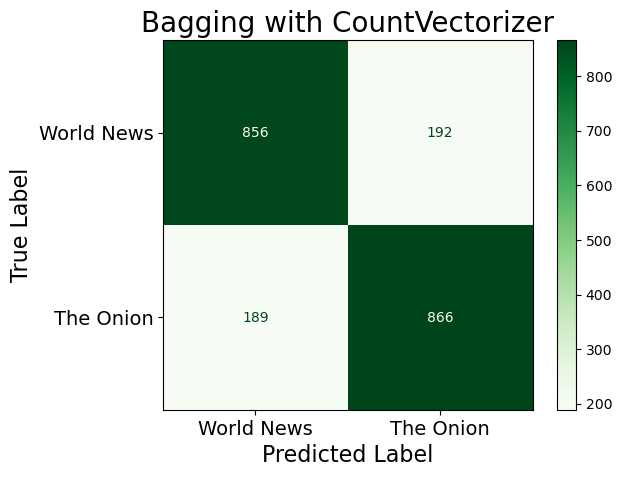

In [9]:
# Creating Metrics
tn_bag_cvec, fp_bag_cvec, fn_bag_cvec, tp_bag_cvec = confusion_matrix(y_test, preds_bag_cvec).ravel()

'''
NOTE:  Negative class is TheOnion as it is alphabetically first and thus the positive class is worldnews
'''

# Setting Up Confusion Matrix
#  Source for color map name:  https://i.stack.imgur.com/cmk1J.png
ConfusionMatrixDisplay.from_estimator(bag_pipe_cvec, X_test, y_test, display_labels=['World News', 'The Onion'], cmap = 'Greens');
plt.title('Bagging with CountVectorizer', fontsize = 20)
plt.xlabel('Predicted Label', size = 16)
plt.ylabel('True Label', size = 16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show();

In [10]:
#dict_ = 
metrics = eval_metrics(X_train, y_train, X_test, y_test, preds_bag_cvec, bag_pipe_cvec, 'bagging_cvec')
metrics

Training Accuracy  Testing Accuracy  Precision Score  \
bagging_cvec             0.9843            0.8188           0.8185   

              Recall Score  
bagging_cvec        0.8209

### 3.2.2 - With TFIDF Vectorizer

In [11]:
# Create Pipeline with TFIDF vectorizer and bagging classifier
bag_pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('bag', BaggingClassifier(random_state=0))
])

# Fit the model to training data
bag_pipe_tvec.fit(X_train, y_train)

# Create predictions:
preds_bag_tvec = bag_pipe_tvec.predict(X_test)

print(f'Training Data Accuracy: {bag_pipe_tvec.score(X_train, y_train)}')
print(f'Testing Data Accuracy: {bag_pipe_tvec.score(X_test, y_test)}')

Training Data Accuracy: 0.9870361560418649
Testing Data Accuracy: 0.806942463147884


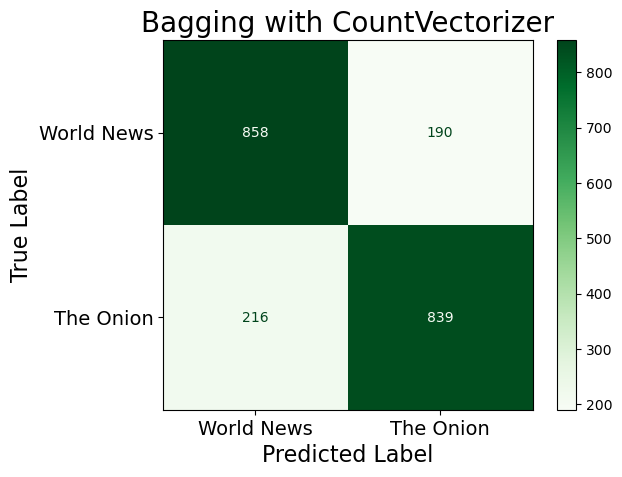

In [12]:
# Creating Metrics
tn_bag_tvec, fp_bag_tvec, fn_bag_tvec, tp_bag_tvec = confusion_matrix(y_test, preds_bag_tvec).ravel()

'''
NOTE:  Negative class is TheOnion as it is alphabetically first and thus the positive class is worldnews
'''

# Setting Up Confusion Matrix
ConfusionMatrixDisplay.from_estimator(bag_pipe_tvec, X_test, y_test, display_labels=['World News', 'The Onion'], cmap = 'Greens');
plt.title('Bagging with CountVectorizer', fontsize = 20)
plt.xlabel('Predicted Label', size = 16)
plt.ylabel('True Label', size = 16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show();

In [13]:
#dict_ = 
metrics = eval_metrics(X_train, y_train, X_test, y_test, preds_bag_tvec, bag_pipe_tvec, 'bagging_tvec')
metrics

Training Accuracy  Testing Accuracy  Precision Score  \
bagging_cvec             0.9843            0.8188           0.8185   
bagging_tvec             0.9870            0.8069           0.8154   

              Recall Score  
bagging_cvec        0.8209  
bagging_tvec        0.7953

## 3.3 - Decision Tree Classifier

Because the Bagging Classifier is using decision trees as the default base estimator, running a full decision tree may provide insight into what the model is doing.

The DecisionTreeClassifier can provide a visual of the decision tree which will indicate how the features are pliting the data at each node.

In [14]:
tree_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('tree', DecisionTreeClassifier(max_depth = 20))
])

tree_pipe.fit(X_train, y_train)
preds_tree_20_cvec = tree_pipe.predict(X_test)

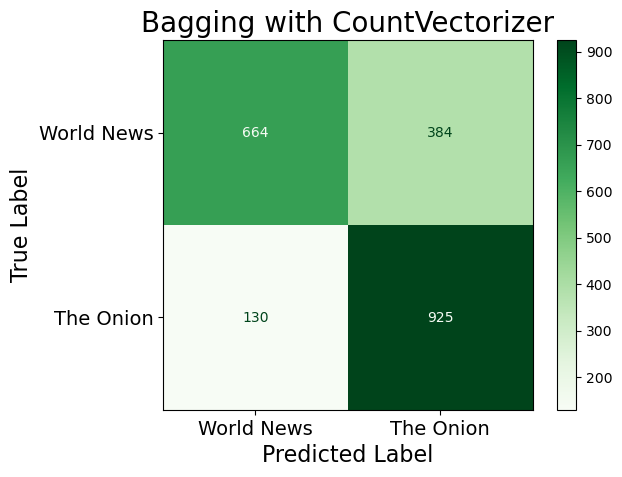

In [15]:
# Setting Up Confusion Matrix
ConfusionMatrixDisplay.from_estimator(tree_pipe, X_test, y_test, display_labels=['World News', 'The Onion'], cmap = 'Greens');
plt.title('Bagging with CountVectorizer', fontsize = 20)
plt.xlabel('Predicted Label', size = 16)
plt.ylabel('True Label', size = 16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show();

In [16]:
eval_metrics(X_train, y_train, X_test, y_test, preds_tree_20_cvec, tree_pipe, 'tree_20_cvec')
# metrics

Training Accuracy  Testing Accuracy  Precision Score  \
bagging_cvec             0.9843            0.8188           0.8185   
bagging_tvec             0.9870            0.8069           0.8154   
tree_20_cvec             0.7901            0.7556           0.7066   

              Recall Score  
bagging_cvec        0.8209  
bagging_tvec        0.7953  
tree_20_cvec        0.8768

In [17]:
plt.figure(figsize=(200, 120))
plot_tree(tree_pipe[1], feature_names=tree_pipe[0].get_feature_names_out(), filled = True);

# 4 - Secondary Data Cleaning
In the preceeding notebook '2-Data_Cleaning', a few characteristics were examined and decidely left in the dataset:
* Hashtags were left in the dataset as they were present in both The Onion data and the World News data
* Both 'The Onion' and 'World News' were mentioned in a subset of the titles, likely making it easy for them to be identified as belonging to the corresponding subreddits

#### TItles matching these characteristics will be removed.
## Reasoning:
As it was invesitgated above, classifiers using some form of decision tree model were heavily utilized, and will continue to be heavily utilized in some for m or another going forward.  By looking at the decision tree, decisions are being made based on the presence of key words and phases.  For words like "onion" and "worldnews," the model can very likely train to idenify these titles and correctly categorize them with ease.  The problem that this creates however, is that the language of the title itself (where the satire or absurdist humor may actually be occuring) could be of little or no importance to the model and prevents the model truly attempting to identify humor.

In the case of the hashtags, this is extra information that does not serve as part of the humor and may further complicate efforts to include things such as sentiment analysis and subjectivity analysis both of which may play a role in identifying humor versus actual news.  This model will seek to incorporate those features into subsequent models.

In [18]:
# Source to reset pandas column width:  https://pandas.pydata.org/docs/reference/api/pandas.reset_option.html
# Source to widen pandas columns:  https://stackoverflow.com/questions/11707586/how-do-i-expand-the-output-display-to-see-more-columns-of-a-pandas-dataframe
pd.reset_option('all')
pd.set_option('display.max_colwidth', 200)

C:\Users\Dan\anaconda3\lib\site-packages\pandas\_config\config.py:653: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
C:\Users\Dan\anaconda3\lib\site-packages\pandas\_config\config.py:653: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


## 4.1 - Process or Drop Titles Directly Referencing the Subreddit Name

In [19]:
# Find all titles with some variation of World News

# The regex code here was created with the help of the following sources:
# Source:  https://stackoverflow.com/questions/18402416/regular-expression-to-match-a-word-or-its-prefix
# Source:  https://stackoverflow.com/questions/20462834/python-using-str-replace-with-a-wildcard
# Source:  https://regex101.com/
# Source:  https://stackoverflow.com/questions/5633533/regular-expression-for-matching-parentheses
# Source:  https://stackoverflow.com/questions/4007302/regex-how-to-match-an-optional-character
# Source:  https://www.regular-expressions.info/optional.html
# Source:  https://stackoverflow.com/questions/9655164/regex-ignore-case-sensitivity
# Source:  https://stackoverflow.com/questions/34583904/javascript-regex-ignore-case-for-specific-capture-group
# Source:  https://stackoverflow.com/questions/7548787/regex-for-and-not-operation

'''
The regex expression below will (in order or characters left to right):
- outer () - says to match all inside the parentheses
- /{0,1}r{0,1}/{0,1} - find a string with or without each of  /, r, and /
- [wW]orld[nN]ews - find worldnew optionally capitalized
- ( Live Thread: )? - it may have this text after it, if so find it, if not, don't
- | either or
- outer () - says to match all inside the parenthese
- \( - backslash tells it to treat left parenthesis as character
- Thread # - where it says 'Thread #'
- \d{1,} - \d any digit, {1,} at least one character long
- \) - backslash tells it to treat right parenthesis as character
'''

# Create the regex string
regex_string = '(/{0,1}r{0,1}/{0,1}[wW]orld[nN]ews( Live Thread: )?)|( \(Thread #\d{1,}\))'

print(reddit[reddit['title'].apply(lambda title: len(re.findall(regex_string, title))) > 0].shape)
reddit[reddit['title'].apply(lambda title: len(re.findall(regex_string, title))) > 0].head()

(22, 2)


subreddit  \
3376   TheOnion   
5597  worldnews   
5786  worldnews   
5857  worldnews   
6085  worldnews   

                                                                                                                                                                                                        title  
3376  U.S. diplomats forced by China to undergo anal swab testing for Covid-19 after Biden raised "fundamental concerns" about Beijing's "coercive and unfair economic practices and human rights abuses i...  
5597                                                                                                                      /r/WorldNews Live Thread: Russian Invasion of Ukraine Day 425, Part 1 (Thread #566)  
5786                                          r/worldnews Some have forgiven him. Some can’t. Truck driver who killed 16 in Humboldt Broncos crash says ‘as long as I’m alive, I’m going to think about them’  
5857                                                                                                                      /r/WorldNews Live Thread: Russian Invasion of Ukraine Day 424, Part 1 (Thread #565)  
6085                                                                                                                      /r/WorldNews Live Thread: Russian Invasion of Ukraine Day 423, Part 1 (Thread #564)

#### OBSERVATIONS:
* As was observed in the preceeding notebook, many of the titles have the exact same title name.  This will present the same problem as having 'worldnews' in the title.  It is presumaly very easy for the model to train to identify these titles
* The first title is actually from The Onion data that were collected, however, it is no longer on the reddit, and appears to not be a legitimate title. It will be removed
* Index number 5786 is a legitimate new title and will be kept, and 'r/worldnews' will be removed

In [20]:
# Create the index list to drop and drop the index of the title to be kept from the Observations above
bad_titles = list(reddit[reddit['title'].apply(lambda title: len(re.findall(regex_string, title))) > 0].index)
bad_titles.remove(5786)

In [21]:
# Find all titles with the words
reddit[reddit['title'].str.lower().str.find('onion') > -1].head(30)

subreddit  \
83   TheOnion   
165  TheOnion   
173  TheOnion   
200  TheOnion   
218  TheOnion   
235  TheOnion   
281  TheOnion   
289  TheOnion   
378  TheOnion   
382  TheOnion   
446  TheOnion   
513  TheOnion   
554  TheOnion   
583  TheOnion   
617  TheOnion   
701  TheOnion   
711  TheOnion   
751  TheOnion   
752  TheOnion   
783  TheOnion   
790  TheOnion   
798  TheOnion   
818  TheOnion   
830  TheOnion   
837  TheOnion   
840  TheOnion   
867  TheOnion   
900  TheOnion   
912  TheOnion   
938  TheOnion   

                                                                                                                                                                                                       title  
83                                                                                                                                                                                   Not the onion this time  
165                                                                          After 232 years of news gathering, this is The Onion’s first front page to be printed in Madison, Wisconsin on August 29, 1988.  
173                                                                                                                                      ‘Succession’ Season 4: The Onion’s Predictions For The Final Season  
200                                                                                                                                                            The Onion Film Standard: John Wick: Chapter 4  
218                                                                                                                                                      The Onion’s Exclusive Interview With Stormy Daniels  
235                                                                                                                                                        The Onion Film Standard: Shazam! Fury Of The Gods  
281                                                                                                                                    The Onion Looks Back At Pope Francis’ Last 10 Years At A Dead End Job  
289                                                                                                                                                                  The Onion Film Standard: Oscars Edition  
378                                                                                                                                    ‘The Onion’ Accidentally Sent Our Sex Columnist To Interview The Pope  
382                                                                                                                                                        The Onion’s Exclusive Interview With J.K. Rowling  
446                                                                                                                                                                   Onion Sports’ Guide To Super Bowl LVII  
513                                                                                                                                                         Onion Sports’ NFL Conference Championships Picks  
554                                                                                                                                                                 Onion Sports’ NFL Divisional Round Picks  
583                                                                                                                                                                Onion Sports’ NFL Wild Card Weekend Picks  
617                                                                                                                                                                          Onion Sports’ NFL Week 18 Picks  
701                                                                                                                                                         This oni

In [22]:
# Check the end of this dataset to see if any world news titles have the word 'onion' in them
reddit[reddit['title'].str.lower().str.find('onion') > -1].tail()

subreddit                                                title
5258  TheOnion      The Onion Looks Back At 'It's A Wonderful Life'
5260  TheOnion  The Onion’s Guide To The 2020 Democratic Candidates
5287  TheOnion        Onion Explains: Global Nuclear Proliferation​
5312  TheOnion                  Onion is aux what he gonna play doe
5334  TheOnion                       The Onion Presents The Topical

#### OBSERVATIONS:
* By looking at both the 'head' and 'tail' of the data filtered on titles containing the word 'onion,' it can be concluded that 'onion' is only present in The Onion data
* Many of the titles above containing 'onion' would be indiscernible from legitimate new articles if onion was removed

**Discussion:**
In regards to the second bullet, while many articles by The Onion are themselves satirical or absurdist statements, these particular onion titles have no humorous characteristics as the article itself contains the satirical text.  Thus, for the sake of this model intending to identify satire or absurdist humor, there is really no value in keeping these posts as even a human could see them as legitimate news titles from a real new agency.

Some of the titles with 'onion' in them still do contain enough salavageable text that is obviously humorous, but the filtering and text searching required to isolate them would be more time-consuming to implement.  These titles will be removed, and this action can be further justified with the knownledge that there are a few hundred more remaining titles from the onion than from world news.  Thus, this is an opportunity to even-out the classes.

In [23]:
# Append the full list of articles containing 'onion' identified above to the bad_titles list

for title in list(reddit[reddit['title'].str.lower().str.find('onion') > -1].index):
    bad_titles.append(title)

### 4.1.1 - Drop Titles and Process Identified World News Title

In [24]:
reddit.drop(index=bad_titles, inplace=True);

In [25]:
# Find all titles with some variation of World News

# Create the regex string from before
regex_string = '(/{0,1}r{0,1}/{0,1}[wW]orld[nN]ews( Live Thread: )?)|( \(Thread #\d{1,}\))'

reddit[reddit['title'].apply(lambda title: len(re.findall(regex_string, title))) > 0].head()

subreddit  \
5786  worldnews   

                                                                                                                                                                title  
5786  r/worldnews Some have forgiven him. Some can’t. Truck driver who killed 16 in Humboldt Broncos crash says ‘as long as I’m alive, I’m going to think about them’

In [26]:
# Create the regex string
regex_string = '(/{0,1}r{0,1}/{0,1}[wW]orld[nN]ews( Live Thread: )?)|( \(Thread #\d{1,}\))'

# Find everthing matching that string and replcae with nothing
#  The 'print('success')' portion of the function is to simply ensure that the function only runs once and that it was properly executed
#    Also, .loc was useful where the dataframe inddexes are out of order.  Help with this from:  https://stackoverflow.com/questions/16096627/selecting-a-row-of-pandas-series-dataframe-by-integer-index
#       SOurce for help with re.sub:  https://stackoverflow.com/questions/20462834/python-using-str-replace-with-a-wildcard
reddit['title'].apply(lambda post: re.sub(regex_string,'',post), print('success')).loc[5786]

success


' Some have forgiven him. Some can’t. Truck driver who killed 16 in Humboldt Broncos crash says ‘as long as I’m alive, I’m going to think about them’'

In [27]:
# Now, run the replacement for real this time
reddit['title'] = reddit['title'].apply(lambda post: re.sub(regex_string,'',post), print('success'))

success


## 4.2 - Remove Hashtags 

In [28]:
reddit[reddit['title'].str.lower().str.find('#') > -1]

subreddit  \
52      TheOnion   
411     TheOnion   
478     TheOnion   
839     TheOnion   
845     TheOnion   
...          ...   
9940   worldnews   
10132  worldnews   
10163  worldnews   
10244  worldnews   
10385  worldnews   

                                                                                                                 title  
52                       These are the biggest hidden costs of giving birth in America 😳 #baby #birth #money #hospital  
411                  Parents Explain Why They Are Not Vaccinating Their Children Against Covid-19 #question #askreddit  
478                            #BREAKINGNEWS: The United States has blown itself up so that China can't have it #china  
839                       ⛔️ UNAUTHORIZED ADVERTISEMENT FOR COUNTRY CROCK ⛔️ #nottechnicallysponsored #SpreadTheCrock🧈  
845                    Things You Should Never Say To A Flight Attendant🛩️ #reddit #askreddit #question #viral #travel  
...                                                                                                                ...  
9940               Details of Geraldton drug bust, then Australia&#x27;s biggest meth seizure, can finally be revealed  
10132  State actor involvement in Nord Stream pipeline attacks is &#x27;main scenario&#x27;, says Swedish investigator  
10163                                        China to inspect ships in Taiwan Strait, Taiwan says won&#x27;t cooperate  
10244                 "Sex, Scandal, and a President: The Shocking Story of Stormy Daniels and Donald Trump #trumpnews  
10385                                                                                                 #free_ Palestine  

[61 rows x 2 columns]

In [29]:
# Find all titles with some variation of World News

'''
The regex string below looks to find and # followed by a word and not followed by a number

'''

# Create the regex string from before
regex_string = '#\D\w+'

reddit[reddit['title'].apply(lambda title: len(re.findall(regex_string, title))) > 0]

subreddit  \
52      TheOnion   
411     TheOnion   
478     TheOnion   
839     TheOnion   
845     TheOnion   
856     TheOnion   
865     TheOnion   
875     TheOnion   
885     TheOnion   
893     TheOnion   
911     TheOnion   
921     TheOnion   
943     TheOnion   
955     TheOnion   
966     TheOnion   
974     TheOnion   
986     TheOnion   
999     TheOnion   
1010    TheOnion   
1020    TheOnion   
1031    TheOnion   
1046    TheOnion   
1057    TheOnion   
1075    TheOnion   
1082    TheOnion   
1091    TheOnion   
1099    TheOnion   
1101    TheOnion   
1914    TheOnion   
3244    TheOnion   
3342    TheOnion   
4910    TheOnion   
5161    TheOnion   
5625   worldnews   
5967   worldnews   
6346   worldnews   
6348   worldnews   
6581   worldnews   
6715   worldnews   
6761   worldnews   
6877   worldnews   
7153   worldnews   
7155   worldnews   
7204   worldnews   
7277   worldnews   
7285   worldnews   
7932   worldnews   
8669   worldnews   
8819   worldnews   
9340   worldnews   
9353   worldnews   
9696   worldnews   
9700   worldnews   
9927   worldnews   
9940   worldnews   
10132  worldnews   
10163  worldnews   
10244  worldnews   
10385  worldnews   

                                                                                                                                                                                                         title  
52                                                                                                               These are the biggest hidden costs of giving birth in America 😳 #baby #birth #money #hospital  
411                                                                                                          Parents Explain Why They Are Not Vaccinating Their Children Against Covid-19 #question #askreddit  
478                                                                                                                    #BREAKINGNEWS: The United States has blown itself up so that China can't have it #china  
839                                                                                                               ⛔️ UNAUTHORIZED ADVERTISEMENT FOR COUNTRY CROCK ⛔️ #nottechnicallysponsored #SpreadTheCrock🧈  
845                                                                                                            Things You Should Never Say To A Flight Attendant🛩️ #reddit #askreddit #question #viral #travel  
856                                                                                                                                You HAVE to get one of these at Walgreens 😍 🛁 ❤️ #shopping #deal #bath #yes  
865                                                                                                                 Things Gen Z Hates About Millennials #reddit #askreddit #question #viral #genz #millennial  
875                                                                                                         Archaeologists Discover Ancient Femur That Could Make Mouthwatering Broth 🍖🤤 #history #bones #food  
885                                                                                                          #BREAKINGNEWS: Artemis 1 launched delayed again after rocket go scared #NASA #space #rocket #moon  
893                                                                                                               Honor Our #Troops By Watching Over This Sleeping Soldier 🇺🇸🇺🇸🇺🇸 #patriot #veteran #USA #army  
911                                                                                                                   #BREAKINGNEWS: Authorities have stopped an office shooting planned by this bullied loner  
921                                                                                                          #BREAKINGNEWS: Dumbass Nation Puts Congress In Power Again #politics #midterm #election #congress  
943                                                                                      

#### OBSERVATIONS:
* There are many instances of '\&#x27;' which in some cases should be removed entirely and in other cases should be replaced with an apostrophe.  These will all just be removed as the vectorizers will remove punctuations anyways
    * This removal would best occur frirst
* The hashtags have also been identified and will be removed

In [30]:
# Replacing the exact string '&#x27;' is easily done with the replace method

# Chek to make sure replacements are happening correctly:
reddit['title'].apply(lambda title: title.replace('&#x27;','')).loc[[6348, 10132]]

6348                                          SpaceX Starship: Elon Musks big rocket explodes on test flight
10132    State actor involvement in Nord Stream pipeline attacks is main scenario, says Swedish investigator
Name: title, dtype: object

In [31]:
reddit['title'] = reddit['title'].apply(lambda title: title.replace('&#x27;',''))
reddit.head(2)

subreddit  \
0  TheOnion   
1  TheOnion   

                                                                                         title  
0                                 Idiot Tornado Tears Harmlessly Through Empty Field - YouTube  
1  New Texas Law Requires Schools To Display Image Of God Hung Like A Horse In Every Classroom

In [32]:
reddit[reddit['title'].apply(lambda title: len(re.findall(regex_string, title))) > 0]

subreddit  \
52      TheOnion   
411     TheOnion   
478     TheOnion   
839     TheOnion   
845     TheOnion   
856     TheOnion   
865     TheOnion   
875     TheOnion   
885     TheOnion   
893     TheOnion   
911     TheOnion   
921     TheOnion   
943     TheOnion   
955     TheOnion   
966     TheOnion   
974     TheOnion   
986     TheOnion   
999     TheOnion   
1010    TheOnion   
1020    TheOnion   
1031    TheOnion   
1046    TheOnion   
1057    TheOnion   
1075    TheOnion   
1082    TheOnion   
1091    TheOnion   
1099    TheOnion   
1101    TheOnion   
1914    TheOnion   
3244    TheOnion   
3342    TheOnion   
4910    TheOnion   
5161    TheOnion   
6715   worldnews   
6761   worldnews   
8669   worldnews   
8819   worldnews   
9340   worldnews   
9353   worldnews   
9696   worldnews   
9700   worldnews   
9927   worldnews   
10244  worldnews   
10385  worldnews   

                                                                                                                                                                                                         title  
52                                                                                                               These are the biggest hidden costs of giving birth in America 😳 #baby #birth #money #hospital  
411                                                                                                          Parents Explain Why They Are Not Vaccinating Their Children Against Covid-19 #question #askreddit  
478                                                                                                                    #BREAKINGNEWS: The United States has blown itself up so that China can't have it #china  
839                                                                                                               ⛔️ UNAUTHORIZED ADVERTISEMENT FOR COUNTRY CROCK ⛔️ #nottechnicallysponsored #SpreadTheCrock🧈  
845                                                                                                            Things You Should Never Say To A Flight Attendant🛩️ #reddit #askreddit #question #viral #travel  
856                                                                                                                                You HAVE to get one of these at Walgreens 😍 🛁 ❤️ #shopping #deal #bath #yes  
865                                                                                                                 Things Gen Z Hates About Millennials #reddit #askreddit #question #viral #genz #millennial  
875                                                                                                         Archaeologists Discover Ancient Femur That Could Make Mouthwatering Broth 🍖🤤 #history #bones #food  
885                                                                                                          #BREAKINGNEWS: Artemis 1 launched delayed again after rocket go scared #NASA #space #rocket #moon  
893                                                                                                               Honor Our #Troops By Watching Over This Sleeping Soldier 🇺🇸🇺🇸🇺🇸 #patriot #veteran #USA #army  
911                                                                                                                   #BREAKINGNEWS: Authorities have stopped an office shooting planned by this bullied loner  
921                                                                                                          #BREAKINGNEWS: Dumbass Nation Puts Congress In Power Again #politics #midterm #election #congress  
943                                                                                                           Americans Explain Why They Are Not Voting In The Midterms #reddit #askreddit #politics #election  
955                                                                                                                                    Those things can get BIG 😳😳😳 #fact #viral #bi

In [33]:
# Remove hashtags from titles
reddit['title'] = reddit['title'].apply(lambda title: re.sub(regex_string, '', title));

In [34]:
reddit.shape

(10274, 2)

## 4.3 - Remove Titles of New Agencies
It was observed previously that in some cases, the news agency is listed in the title, and often, the agency name contains the word 'Times'.

These will be further investiaged below.

### 4.3.1 - Initial Investigations

In [91]:
# Search for all entries with 'Times' in them:
reddit[reddit['title'].str.lower().str.find('times') > -1]

subreddit  \
89      TheOnion   
283     TheOnion   
286     TheOnion   
488     TheOnion   
1003    TheOnion   
...          ...   
9339   worldnews   
9477   worldnews   
9677   worldnews   
10037  worldnews   
10433  worldnews   

                                                                                                                  title  
89                                     Study: ‘This Was Back During Covid’ Uttered Average Of 96 Times Per Conversation  
283                                                   Fetus Panics After Ballooning Up To 500 Times Her Original Weight  
286                                                              Ingenious Forms Of Birth Control Used In Ancient Times  
488                                    Biden Casually Tells National Prayer Breakfast He’s Been To Heaven Several Times  
1003                   Guy At Halloween Party Dropped Hundreds On Fancy Pirate Costume He’ll Wear Maybe 50 Times A Year  
...                                                                                                                 ...  
9339                           New York Times: Leaked documents reveal Russia promises bonuses for destroyed NATO tanks  
9477   'Helmet Man of India' sold house to distribute free helmets: Lauded by Nitin Gadkari, Sonu Sood - Times of India  
9677                               Local leadership group in Kafr Qassem condemns Tel Aviv attack | The Times of Israel  
10037                                                    NYTimes: Ukraine War Plans Leak Prompts Pentagon Investigation  
10433                                 Fuels from Russian oil gets backdoor entry into Europe via India - Times of India  

[72 rows x 2 columns]

In [92]:
# It is noticed above that one NYTimes articale has the news agency name at the beginning before a colon.
#  This line of code will look for entries with colons in them
reddit[reddit['title'].str.lower().str.find(':') > -1]

subreddit  \
13      TheOnion   
59      TheOnion   
65      TheOnion   
76      TheOnion   
89      TheOnion   
...          ...   
10481  worldnews   
10483  worldnews   
10485  worldnews   
10486  worldnews   
10502  worldnews   

                                                                                                       title  
13                                                            Quiz: Could You Pass The SpaceX Aptitude Test?  
59                                      Browns GM: ‘If I Could Go Back, I’d Offer Deshaun Watson More Money’  
65                                             Quiz: Could You Pass A History Class In Ron DeSantis’ Florida  
76                                                                         Political Profile: The Dalai Lama  
89                          Study: ‘This Was Back During Covid’ Uttered Average Of 96 Times Per Conversation  
...                                                                                                      ...  
10481                    Air Force: Russia's supply of long-range, high-precision missiles 'nearly' used up.  
10483                             Macron and von der Leyen: Europe’s good cop and bad cop to meet Xi Jinping  
10485                                         Genesis Market: Popular cybercrime website shut down by police  
10486                Genesis Market: Popular cybercrime website shut down by Britain’s National Crime Agency  
10502  ‘We lay like corpses. Then the raping began’: 52 years on, Bangladesh’s rape camp survivors speak out  

[1272 rows x 2 columns]

In [96]:
# It can also be noticed that some agency names are separated by a hyphen with spaces on either side
#  The line of code below will find examples of such
reddit[reddit['title'].str.lower().str.find(' - ') > -1].head(50)

subreddit  \
0      TheOnion   
224    TheOnion   
1129   TheOnion   
2872   TheOnion   
2937   TheOnion   
3146   TheOnion   
3275   TheOnion   
3333   TheOnion   
3339   TheOnion   
3473   TheOnion   
3661   TheOnion   
3665   TheOnion   
4087   TheOnion   
4245   TheOnion   
4246   TheOnion   
4247   TheOnion   
4372   TheOnion   
4747   TheOnion   
4844   TheOnion   
5278   TheOnion   
5343   TheOnion   
5442  worldnews   
5443  worldnews   
5445  worldnews   
5446  worldnews   
5460  worldnews   
5470  worldnews   
5481  worldnews   
5519  worldnews   
5521  worldnews   
5535  worldnews   
5549  worldnews   
5574  worldnews   
5580  worldnews   
5621  worldnews   
5650  worldnews   
5671  worldnews   
5682  worldnews   
5802  worldnews   
5834  worldnews   
5869  worldnews   
5894  worldnews   
5907  worldnews   
5926  worldnews   
5933  worldnews   
5963  worldnews   
6000  worldnews   
6002  worldnews   
6003  worldnews   
6013  worldnews   

                                                                                                                                                                                                        title  
0                                                                                                                                                Idiot Tornado Tears Harmlessly Through Empty Field - YouTube  
224                                                                                                                   Optimism Takes Airdrops to the Next Level with Phase 2 - 5 Million $OP Tokens on Offer!  
1129                                                                                                                                                   Highlight: Tiny Elon Musk #30 - trimetaveler on Twitch  
2872                                                                                                                                                                      Content of Diabetes - Pastelink.net  
2937                                                                                                                                                         Report: Make It Stop - Please, Just Make It Stop  
3146                                                                                                                                                          Deer: Deer Are Fine - Horrifying Planet - Ep. 8  
3275                                                                                                                                                                      Stan Kelly - Curfew And Far Between  
3333                                                                                                                                                      Live From Congress - The Skull Fucking Bill Of 2007  
3339                                                                                                                                 Nissan recalls 800 000 Sentras over brake lights - Car News. Car Reviews  
3473                                                                                                                                                                                    Trigger warning - fyc  
3661                                                                                                                                                                   crowder vs carlson - the GOP civil war  
3665                                                                                                Joe Biden’s Votes Violate Benford’s Law (Mathematics) – Statistically Impossible - Stillness in the Storm  
4087                                                                                                                     American Fascism: A German Writer's Urgent Warning to America - Oliver Markus Malloy  
4245                                                                                                                        

In [94]:
# Yet another way that the news agency name is provided is after a '|' at the end of the title
#  This line of code will find similar examples
reddit[reddit['title'].str.lower().str.find('|') > -1]

subreddit  \
194     TheOnion   
199     TheOnion   
1724    TheOnion   
1824    TheOnion   
3428    TheOnion   
...          ...   
10460  worldnews   
10463  worldnews   
10472  worldnews   
10496  worldnews   
10509  worldnews   

                                                                                                                                                                                                  title  
194                                                                                                                                                                   Optimism | Airdrop | Get free $OP  
199                                                                                                                                                            $OP Drop | Phase 2 right now! | Optimism  
1724                                                                                                                                  Plympton Homer's Face Couch Gag | Season 29 Ep. 13 | THE SIMPSONS  
1824                                                                                             World’s richest man Elon Musk says he’s homeless and ‘rotates’ among friends’ houses | The Independent  
3428                                                                                                          Tom Brady called 'Racist' for winning Super Bowl during Black History Month | 95.7 BIG FM  
...                                                                                                                                                                                                 ...  
10460                                                                                           Credit Suisse ‘could not be saved,’ chairman says in apology to shareholders - National | Globalnews.ca  
10463                                                                                                         Israeli forces attack worshippers in Al-Aqsa Mosque raid | Israel-Palestine conflict News  
10472                                                                            In Poland, the Catholic church backed abortion bans and authoritarian politics. Young people are turning away | Poland  
10496                                                                                                                                           Online trading with Deriv | Simple. Flexible. Reliable.  
10509  A wartime NATO struggles to replace its chief | The job is suddenly politically sensitive and high-profile, driving people to float names like Ursula von der Leyen that are unlikely — for now.  

[302 rows x 2 columns]

In [99]:
# Investigate the use of multiple pipe instances:
regex_string = '\| \w{1,}'
reddit[reddit['title'].apply(lambda title: len(re.findall(regex_string, title))) > 1]

subreddit  \
194     TheOnion   
199     TheOnion   
1724    TheOnion   
4859    TheOnion   
4868    TheOnion   
4876    TheOnion   
4893    TheOnion   
4901    TheOnion   
4905    TheOnion   
4912    TheOnion   
4934    TheOnion   
4949    TheOnion   
4954    TheOnion   
4979    TheOnion   
4989    TheOnion   
5093    TheOnion   
5588   worldnews   
5796   worldnews   
6407   worldnews   
7308   worldnews   
8023   worldnews   
8029   worldnews   
8101   worldnews   
8613   worldnews   
8688   worldnews   
8868   worldnews   
8875   worldnews   
8877   worldnews   
9029   worldnews   
9265   worldnews   
9312   worldnews   
9315   worldnews   
9337   worldnews   
9414   worldnews   
9708   worldnews   
10412  worldnews   
10429  worldnews   

                                                                                                                                                                                                         title  
194                                                                                                                                                                          Optimism | Airdrop | Get free $OP  
199                                                                                                                                                                   $OP Drop | Phase 2 right now! | Optimism  
1724                                                                                                                                         Plympton Homer's Face Couch Gag | Season 29 Ep. 13 | THE SIMPSONS  
4859                                                                                                             Host Leslie Price Confronts The Cursed Scratching Within His Walls | The Topical | Episode 47  
4868                                                                                                              Scientists No Closer To Understanding How Pressing Buzzer Unlocks Door | The Topical | Ep 46  
4876                                                                                                              Porn Industry Leaders Announce Immediate Closures Of All Orifices | The Topical | Episode 45  
4893                                                                                                        Doctors Encourage Women To Do Breast Self-Exams To See If They Need Implants | The Topical | Ep 43  
4901                                                                                                        National Park Service Under Fire For Wasting $40M To Pamper A Charming Moose | The Topical | Ep 41  
4905                                                                                                           Russia Pledges To Run Completely Positive Disinformation Campaign In 2020 | The Topical | Ep 40  
4912                                                                                                      God Possesses Pope Francis’s Body, Spins Head Around In Miraculous Sunday Mass | The Topical | Ep 39  
4934                                                                                                        Dark, Ominous Storm Clouds Atop Mount Money Indicate Recession Could Be Near | The Topical | Ep 37  
4949                                                                                                           Fiat Recalls More Than 10,000 Cars For Not Looking Small And Weird Enough | The Topical | Ep 35  
4954                                                                                                          Outbreaks In Victorian England Confirm Coronavirus Can Spread Through Time | The Topical | Ep 34  
4979                                                                                                                  Son-Of-A-Bitch Mouse Solves Maze Researchers Spent Months Building | The Topical | Ep 31  
4989                                                                                                        Dow

#### OBSERVATIONS:
* "Times" is a common word used in the names of new agencies that could be used by the model to easily indicate that the title is from World News
    * Simply removing this word from posts would likely do more harm than good to the data
* Colons are used to indicate the news agency in some instances. In other instances, they are legitimately part of the title text
    * Simply removing text before or after colons would likely have a more of a negative impact on the data
* Hyphens are also used to denote the news agency, but again, they are also used to be legitimately part of the title text
    * In many instances, removing the text after a hyphen would sucesfully remove the name of news agencies and other potentially idenifying features
* Pipes '|' are used quite frequently to designate the news agency, though there are a few exceptions to where they are at the beginning on the title before the title text
    * In some situations where multiple pipes are used, the posts are very clearly advertisements which were not removed by the moderators prior to webscraping.  In such cases, these posts are not legitimate titles
    * It appears that in the majority of cases, removing text after a pipe would remove identifying features in the title
* For each of the characteristics noted above, there are exceptions where the noted words and characters are embedded in the actual article title within the title and are NOT namig the news agency.  These examples however appear to be relatively few
    * Overall, the 

Only a very advanced function could automatically determine when and when not to remove these characters, and generating a list of news agency names to be filtered would be impractical at this point.  Simple functions would do an imperfect job of cleaning as some true title text will be determined to be a news agency and will be removed, leaving little to no content.

Thus, in order to improve the integrity of the titles by removing news agency names, a smaller number of titles will be significantly shortened.  **For this analysis, the fact that some titles will become damaged is something that will need to be noted as a possible source of error.**

**To do this, text after pipes and hyphens separated by spaces will be removed.**

### 4.3.2 - Removing Text After Pipes and Hyphens (separated by spaces)

In [103]:
# =====  PIPES  ===========================


# Test a regular expresion functions before remvoing:
# The string below was copied from the autputs above:
text_string = "Taiwan's legislature condemns China's 'barbaric actions' in strait | Taiwan News | 2023-04-11 14:55:00"

# This string will look for pipes folloowed by a space and words separated by spaces or non-word characters thereafter
regex_string = '\| [\w \W]+'

re.findall(regex_string, text_string)

['| Taiwan News | 2023-04-11 14:55:00']

In [110]:
# Now run the substitution string to check:
reddit['title'].apply(lambda title: re.sub(regex_string, '', title)).loc[8877]

"Taiwan's legislature condemns China's 'barbaric actions' in strait "

In [105]:
# Finally, make the removal permanent:
reddit['title'] = reddit['title'].apply(lambda title: re.sub(regex_string, '', title))

In [108]:
# =====  HYPHENS  ===========================


# Test a regular expresion functions before remvoing:
# The string below was copied from the autputs above:
text_string = 'Survivor of doomed Pearl Harbor warship dies at 102 - BBC News'

# This string will look for pipes folloowed by a space and words separated by spaces or non-word characters thereafter
regex_string = '\- [\w \W]+'

re.findall(regex_string, text_string)

['- BBC News']

In [111]:
# Now run the substitution string to check:
reddit['title'].apply(lambda title: re.sub(regex_string, '', title)).loc[5549]

'Survivor of doomed Pearl Harbor warship dies at 102 '

In [112]:
# Finally, make the removal permanent:
reddit['title'] = reddit['title'].apply(lambda title: re.sub(regex_string, '', title))

### 4.3.3 - Re-examine Titles with "Times" in the title

In [115]:
reddit[reddit['title'].str.find('Times') > -1]

subreddit  \
89      TheOnion   
283     TheOnion   
286     TheOnion   
488     TheOnion   
1003    TheOnion   
1048    TheOnion   
1260    TheOnion   
1484    TheOnion   
1989    TheOnion   
2080    TheOnion   
2243    TheOnion   
2515    TheOnion   
2596    TheOnion   
2791    TheOnion   
2863    TheOnion   
3222    TheOnion   
3898    TheOnion   
4237    TheOnion   
4553    TheOnion   
4611    TheOnion   
4620    TheOnion   
4805    TheOnion   
4982    TheOnion   
5123    TheOnion   
5174    TheOnion   
5306    TheOnion   
5318    TheOnion   
5382    TheOnion   
5536   worldnews   
5797   worldnews   
6005   worldnews   
6791   worldnews   
6793   worldnews   
7575   worldnews   
7811   worldnews   
7813   worldnews   
8271   worldnews   
8274   worldnews   
8275   worldnews   
9002   worldnews   
9339   worldnews   
10037  worldnews   

                                                                                                                                                                                                         title  
89                                                                                                                            Study: ‘This Was Back During Covid’ Uttered Average Of 96 Times Per Conversation  
283                                                                                                                                          Fetus Panics After Ballooning Up To 500 Times Her Original Weight  
286                                                                                                                                                     Ingenious Forms Of Birth Control Used In Ancient Times  
488                                                                                                                           Biden Casually Tells National Prayer Breakfast He’s Been To Heaven Several Times  
1003                                                                                                          Guy At Halloween Party Dropped Hundreds On Fancy Pirate Costume He’ll Wear Maybe 50 Times A Year  
1048                                                                                                                                               Times Tough For Local Man Who Actually Is Superior To Women  
1260                                                                                                                                                   Most Glaring Times Trump's Children Have Broken The Law  
1484                                                                                                                         Department Of Transportation Reduces Commute Times By Adding Highway Nitro Strips  
1989                                                                                                                     Judge Dismisses ‘New York Times’ Libel Suit Brought By Cannibal Terrorist Sarah Palin  
2080                                                                                                                                                                  ‘New York Times’ Buys Online Game Wordle  
2243                                                                                                                                 Shitty Music Has Helped Moron Through Hardest Times In His Pointless Life  
2515                                                                                                               ‘New York Times’ Copy Editor Recommends Tom Morello Cut Down Use Of Wah-Wah Pedal In Column  
2596                                                                                                                          ‘New York Times’ Releases Jerry Jones’ Hateful Telegrams Slamming Ottoman Empire  
2791                                                                                                   Latest Climate Change Report Just Heartfelt Farewell Letter Telling Humanity To Remember The Good Times  
2863       

#### OBSERVATIONS:
There are a few instances where news agency names like "New York Times" are present as identifiers of an NYT sotry.  However, in more cases, The New York Times is actually the subject of the news title and would need to be kept.  There are also other news agencies with "times" in their names, and even more news agencies without times in their names which have liekly slipped past all the data processing that has been done.  It can also be seen that the word "times" is acutally present in a number of articles titles from The Onion.  So this may not have as much of an identifying effect as previously thought.

**Since it is unreasonable to read every title, and spot-removals are not scalable to unseen data, no actions will be taken to find and replace new agency names.**

## 4.4 - Remove Emojis and Unnecessary Punctuation
In regards to identifying satire and humor, it cannot be determined in this analysis if the emojis are used in a humorous manner or if they were simply added for effect.  They are present in titles from both subreddits but emojis will likely only serve to confuse the the models.  Thus they will be removed.

In [122]:
# Test the regex expression to remove emojis:

# This expression will remove emojis and most punctuation which won't be necessary for the algorithms used.
# Source to help with this code:  https://stackoverflow.com/questions/7548787/regex-for-and-not-operation
'''
This regex will find all non word items and exclude all of the following characters (a space is the first character):  ' &$%\-#/'

The characters selected to be excluded above were iteratively chosen by examining the outputs of the find all code below.  
The word vectorizers will do the vast majority of the punctuation removal, but here, these characters are being skipped 
as replacing them with nothing may change the meaning of some words or combine two words that shoud not be together.

'''
#regex_string2 = "((?=[^ &$%\-#/])\W)"
regex_string = "((?=[^ &$%\-#/])\W)"
[re.findall(regex_string2, x) for x in reddit.title if len(re.findall(regex_string2, x))>0]

[['?'],
 ['.'],
 ['’', '’'],
 [':', '?'],
 ['‘', '’'],
 [','],
 ['‘', ',', '’', '’'],
 ['.', '.'],
 ['’'],
 ['‘', ',', '’'],
 ['’'],
 ['‘', '’'],
 [','],
 ['‘', '’', '‘', '’'],
 ['‘', '?', '’'],
 ['’'],
 ['?'],
 ['😳'],
 ['.'],
 ['‘', '’'],
 [':', '‘', ',', '’', '’'],
 ['!'],
 ['’'],
 [':', '’'],
 ['’'],
 [','],
 [':'],
 ['’'],
 ['’'],
 [':', '‘', '’'],
 ['‘', ',', '’'],
 ['’'],
 ['’'],
 ['’', ',', ','],
 [','],
 ['’'],
 [':', "'", "'", '(', ')'],
 ['‘', ':', '’'],
 ['…', '.'],
 ["'", ','],
 ['’'],
 [','],
 ['’', ':'],
 ['’'],
 [',', ','],
 ['?', '.'],
 ['.'],
 [','],
 ['‘', ',', '’'],
 ['’'],
 ['’'],
 ['’'],
 [':'],
 ['’'],
 ['’', '’'],
 [':', '‘', '’'],
 [':', '‘', '’'],
 [':'],
 ['.', '.'],
 ['’'],
 ['’'],
 [','],
 ['‘', '’', ',', '’'],
 ['‘', '’'],
 ['‘', '’', '.'],
 [','],
 ['‘', '.', '’'],
 ['’', '‘', '’'],
 [',', '’', ',', ','],
 ['’', ',', '’'],
 ['’'],
 ['‘', '’'],
 [':', '’'],
 ['’'],
 [':', '’'],
 ['.', '.'],
 ['’'],
 ['‘', '’'],
 ['‘', '’'],
 ['.', '.'],
 ["'"],
 ['’'],
 ['.

In [123]:
reddit['title'].apply(lambda title: re.sub(regex_string, '', title)).loc[839]

' UNAUTHORIZED ADVERTISEMENT FOR COUNTRY CROCK   '

In [126]:
reddit['title'] = reddit['title'].apply(lambda title: re.sub(regex_string, '', title))

## 4.5 - Remove Starting and Trailing Spaces

In [132]:
# Test the strip function to ensure that it will work:
reddit['title'].apply(lambda title: title.strip()).loc[839]

'UNAUTHORIZED ADVERTISEMENT FOR COUNTRY CROCK'

In [133]:
# Implement Strip Function on all entries:
reddit['title'] = reddit['title'].apply(lambda title: title.strip())

## 4.6 - Make a Second Dataset to Lemmatize and Compare Performance

In [135]:
# Copy the dataset up to this point
reddit_lem = reddit.copy()

In [137]:
# Test out lemmatizer
lemmer = WordNetLemmatizer()

lemmer.lemmatize('Latest Climate Change Report Just Heartfelt Farewell Letter Telling Humanity To Remember The Good Times')

'Latest Climate Change Report Just Heartfelt Farewell Letter Telling Humanity To Remember The Good Times'

In [139]:
# While lemmatizer is not doing much of anything, it will be run anyways:
reddit_lem['title'].apply(lambda x: lemmer.lemmatize(x))

0                                                 Idiot Tornado Tears Harmlessly Through Empty Field
1        New Texas Law Requires Schools To Display Image Of God Hung Like A Horse In Every Classroom
2                                  New Poll Finds Americans Would Respect Biden More If He Shot Them
3                                          Could You Pass Racial Discrimination Training At Fox News
4                                                                  Dog And Owner Having Public Fight
                                                    ...                                             
10506                 Diners in Japan arrested for dipping own chopsticks in communal bowl of ginger
10507                             200 Russian Journalists Sign Letter Demanding US Reporters Release
10508                                         Foxconn founder Gou to run for Taiwan presidency again
10509                                                  A wartime NATO struggles to replace 

In [143]:
# This will count the number of times that the lemmatized verison of the title is not the same as the original version
(reddit_lem['title'] != reddit_lem['title'].apply(lambda x: lemmer.lemmatize(x))).sum()

0

#### OBSERVATIONS:
Lemmatizing is doing exactly nothing since it made no changes to any of the titles.  Thus, this step will not be needed.

---
# Testing Ground ---------------------------------

In [150]:
reddit['subreddit'].value_counts(normalize=True)

TheOnion     0.507105
worldnews    0.492895
Name: subreddit, dtype: float64

In [151]:
X = reddit['title']
y = reddit['subreddit'].map({'TheOnion': 1, 'worldnews': 0})

## XX - Train Test Split:  80/20, Random State: 0

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# X - Initial Modeling

In [153]:
'''
This cell can be re-run as-needed to reset the metrics dataframe.
'''

metrics = pd.DataFrame()

In [154]:
'''
This cell will seek to define a function that will preformance metrics to a 'metrics' dataframe.

This can be called for each model to add the model's performance metrics to the running list of 
models and metrics in the global 'metrics" dataframe'
'''

def eval_metrics(X_train, y_train, X_test, y_test, preds, model, name):
    
    # Create all important scores from the arguments above
    tr_acc = round(model.score(X_train, y_train), 4),
    ts_acc =  round(model.score(X_test, y_test), 4),
    prec = round(precision_score(y_test, preds), 4),
    recall = round(recall_score(y_test, preds), 4)  

    # Create a temporary dictionary to store the scores created above                 
    temp_dict = {
        'Training Accuracy': tr_acc,
        'Testing Accuracy':  ts_acc,
        'Precision Score': prec,
        'Recall Score': recall
    }
    
    # Create a temporary dataframe to eventually be added to the global metrics dataframe
    df = pd.DataFrame(temp_dict, index = [name])
    
    # Concatenate the global metrics dataframe with the one just produced
    #  Source for calling a global variable:  https://stackoverflow.com/questions/10588317/python-function-global-variables
    global metrics
    return pd.concat([metrics, df])   

## X.X - Null Model (Target Variable Distributions)

In [155]:
y.value_counts(normalize=True)

1    0.507105
0    0.492895
Name: subreddit, dtype: float64

## X.X - Initial Default Parameter Bagging Classifier

### X.X.X - With CountVectorizer

In [158]:
# Create Pipeline with count vectorizer and bagging classifier
bag_pipe_cvec = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('bag', BaggingClassifier(random_state=0))
])

# Fit the model to training data
bag_pipe_cvec.fit(X_train, y_train)

# Create predictions:
preds_bag_cvec = bag_pipe_cvec.predict(X_test)

print(f'Training Data Accuracy: {bag_pipe_cvec.score(X_train, y_train)}')
print(f'Testing Data Accuracy: {bag_pipe_cvec.score(X_test, y_test)}')

Training Data Accuracy: 0.9869813845966663
Testing Data Accuracy: 0.8428223844282239


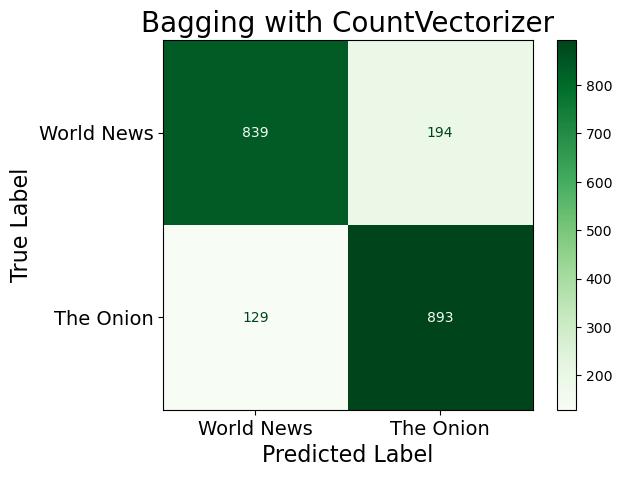

In [159]:
# Creating Metrics
tn_bag_cvec, fp_bag_cvec, fn_bag_cvec, tp_bag_cvec = confusion_matrix(y_test, preds_bag_cvec).ravel()

'''
NOTE:  Negative class is TheOnion as it is alphabetically first and thus the positive class is worldnews
'''

# Setting Up Confusion Matrix
#  Source for color map name:  https://i.stack.imgur.com/cmk1J.png
ConfusionMatrixDisplay.from_estimator(bag_pipe_cvec, X_test, y_test, display_labels=['World News', 'The Onion'], cmap = 'Greens');
plt.title('Bagging with CountVectorizer', fontsize = 20)
plt.xlabel('Predicted Label', size = 16)
plt.ylabel('True Label', size = 16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show();

# Other

# Eventually run this towards the end